In [5]:
import os
import ROOT
from ROOT import gStyle
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)


def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(histogram_info[histogram_name][0],histogram_info[histogram_name][1],data)
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][2])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)
    
    ###################################################################################################
    
    #######                              Plotting part                                     ############
    
    ###################################################################################################
    
    
    
    gStyle.SetOptStat(1111111)
    gStyle.SetStatY(0.97);                
    gStyle.SetStatX(1.0);
    gStyle.SetStatW(0.12);                
    gStyle.SetStatH(0.12);

    canvas3 = ROOT.TCanvas("canvas3")
    canvas3.cd()

    ##### DRAWING TOP PAD, SETTING MARGINS #######

    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
    pad1.SetTopMargin(0.03)
    pad1.SetRightMargin(0.03)
    pad1.SetLeftMargin(0.08)
    pad1.SetBottomMargin(0.0)
    pad1.Draw ()
    pad1.cd ()

    ###### SETTING STATS BOX POSITION ######

    gStyle.SetStatY(0.93);                
    gStyle.SetStatX(0.99);
    gStyle.SetStatW(0.1);                
    gStyle.SetStatH(0.1);
    
    data_subtracted.SetLineColor(ROOT.kRed)

    data_subtracted.Draw("pe")
    signal.Draw("HIST same")
    data_subtracted.Draw("same")

    pad1.SetLogy()


    data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))

    legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
    legend . AddEntry ( data_subtracted ," Data subtracted")
    legend . AddEntry ( signal ,signal_name)
    gStyle.SetLegendBorderSize(0)
    legend . SetLineWidth (0)
    legend . Draw ()

    data.SetTitle("")
    l=ROOT.TLatex()
    l.SetNDC ()
    l.DrawLatex(0.9,0.7,"Z#rightarrow #mu#mu")

    canvas3.cd()
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
    pad2.SetRightMargin(0.03)
    pad2.SetLeftMargin(0.08)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.0)
    pad2.Draw ()
    pad2.cd ()
    ratio.Draw ("pe")
    ratio.SetTitle("")
    ratio.SetStats(0)
    ratio . GetYaxis (). SetRangeUser (0.1 ,2.0)
    ratio . GetXaxis (). SetRangeUser (s ,e)
    ratio . GetYaxis (). SetTitle ("MC/DATA")
    ratio . GetYaxis (). SetTitleSize (0.15)
    ratio . GetYaxis (). SetTitleOffset (0.25)
    #ratio . GetXaxis (). SetTitle (histos[i][3])
    ratio . GetXaxis (). SetTitleSize (0.09)
    ratio.GetXaxis().SetLabelSize(0.10)
    ratio.GetYaxis().SetLabelSize(0.08)


    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######

    line = ROOT . TLine (s ,1 ,e,1)
    line . SetLineColor ( ROOT . kBlack )
    line . SetLineWidth (2)
    line2 = ROOT . TLine (s ,1.2 ,e,1.2)
    line2 . SetLineColor ( ROOT . kBlack )
    line2 . SetLineWidth (1)
    line2 . SetLineStyle(2)
    line3 = ROOT . TLine (s ,0.8 ,e,0.8)
    line3 . SetLineColor ( ROOT . kBlack )
    line3 . SetLineWidth (1)
    line3 . SetLineStyle(2)
    line4 = ROOT . TLine (s ,1.4 ,e,1.4)
    line4 . SetLineColor ( ROOT . kBlack )
    line4 . SetLineWidth (1)
    line4 . SetLineStyle(2)
    line5 = ROOT . TLine (s ,0.6 ,e,0.6)
    line5 . SetLineColor ( ROOT . kBlack )
    line5 . SetLineWidth (1)
    line5 . SetLineStyle(2)
    line6 = ROOT . TLine (s ,1.6 ,e,1.6)
    line6 . SetLineColor ( ROOT . kBlack )
    line6 . SetLineWidth (1)
    line6 . SetLineStyle(2)
    line7 = ROOT . TLine (s ,0.4 ,e,0.4)
    line7 . SetLineColor ( ROOT . kBlack )
    line7 . SetLineWidth (1)
    line7 . SetLineStyle(2)
    line8 = ROOT . TLine (s ,1.8 ,e,1.8)
    line8 . SetLineColor ( ROOT . kBlack )
    line8 . SetLineWidth (1)
    line8 . SetLineStyle(2)
    line9 = ROOT . TLine (s ,0.2 ,e,0.2)
    line9 . SetLineColor ( ROOT . kBlack )
    line9 . SetLineWidth (1)
    line9 . SetLineStyle(2)
    line . Draw (" same ")
    line2 . Draw (" same ")
    line3 . Draw (" same ")
    line4 . Draw (" same ")
    line5 . Draw (" same ")
    line6 . Draw (" same ")
    line7 . Draw (" same ")
    line8 . Draw (" same ")
    line9 . Draw (" same ")
    line . Draw (" same ")
    
    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        print("m range = ",ratio.GetBinCenter(i),"SF = ",round(ratio.GetBinContent(i),3),)
        if ratio.GetBinContent(i)>0 or i==1:
            x_values.append(ratio.GetBinLowEdge(i))
            y_values.append(round(ratio.GetBinContent(i),3))
            y_uncern.append(ratio.GetBinError(i))
        else : 
            break

    os.chdir(path_to_samples)
    sufix = signal_name.strip('.root').split('_')[1]
    canvas3.Print(sufix+"_ratio.pdf")
    
    return [x_values,y_values,y_uncern]

In [29]:

path = "/home/diego/HEP/VBF-Analysis/MuMu/Plots/CRc/"
signal = "Zmumu_MG"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

fitting_data=ratio_subtracted_plot(path_to_samples=path,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
print(fitting_data[0])
print(fitting_data[1])
print(fitting_data[2])

0.0
5000.0
m range =  125.0 SF =  0.0
m range =  375.0 SF =  0.74
m range =  625.0 SF =  0.719
m range =  875.0 SF =  0.614
m range =  1125.0 SF =  0.62
m range =  1375.0 SF =  0.508
m range =  1750.0 SF =  0.503
m range =  2250.0 SF =  0.495
m range =  2750.0 SF =  0.368
m range =  3500.0 SF =  1.165
m range =  4500.0 SF =  -0.915
[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 2000.0, 2500.0, 3000.0]
[0.0, 0.74, 0.719, 0.614, 0.62, 0.508, 0.503, 0.495, 0.368, 1.165]
[0.0, 0.015408407790554763, 0.01747361935694037, 0.02377112638635831, 0.03764529276709727, 0.04933285720463621, 0.05916518547469906, 0.11888940929986945, 0.23193672406643887, 0.6154728512615928]


Info in <TCanvas::Print>: pdf file MG_ratio.pdf has been created


[250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 2000.0, 2500.0, 3000.0] [0.74, 0.719, 0.614, 0.62, 0.508, 0.503, 0.495, 0.368, 1.165]


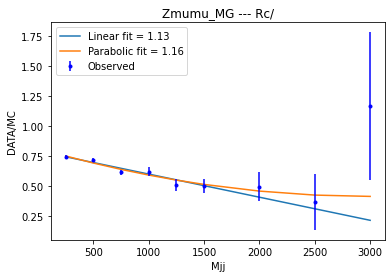

In [30]:
from scipy.optimize import curve_fit

def correction_shape(mjj,slope,level):
    return np.piecewise(mjj,[mjj<=1250],[lambda mjj : slope*mjj+level-1250.0*slope, lambda mjj : level])
    
def linear_shape(mjj,slope,level):
    return slope*mjj+level

def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c

def chi_square(model, slope, level, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-2))

def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))

xdata = fitting_data[0][1:]
ydata = fitting_data[1][1:]
error = fitting_data[2][1:]

print(xdata,ydata)

lfit, lcov = curve_fit(linear_shape, xdata, ydata,sigma=error)
dlfit, dlcov = curve_fit(parabolic_shape, xdata, ydata,sigma=error)

plt.plot(xdata,linear_shape(np.array(xdata),lfit[0],lfit[1]))
plt.plot(xdata,parabolic_shape(np.array(xdata),dlfit[0],dlfit[1],dlfit[2]))
plt.errorbar(xdata, ydata,yerr=fitting_data[2][1:],fmt='b.')
plt.legend(["Linear fit = "+str(round(chi_square(linear_shape,lfit[0],lfit[1],xdata,ydata,fitting_data[2][1:]),2)),
"Parabolic fit = "+str(round(chi_square2(parabolic_shape,dlfit[0],dlfit[1],dlfit[2],xdata,ydata,fitting_data[2][1:]),2)),"Observed"],loc ="upper left")
plt.title(signal+" --- "+path[-3:])
plt.xlabel('Mjj') 
plt.ylabel('DATA/MC') 
plt.savefig(path+"/"+signal+".pdf")


In [ ]:
x=np.linspace(0,5000,1000)

zmm=parabolic_shape(x,-5.736E-04,2.602E-01,-6.469E-04)
zee=parabolic_shape(x,-2.164E-04,5.066E-01,-1.939E-04)
average=parabolic_shape(x,-2.616E-04,3.834E-01,-4.204E-04)

In [ ]:
plt.plot(x,zmm)
plt.plot(x,zee)
plt.plot(x,average)
plt.legend(["Zmm","Zee","Average"])

In [198]:
print(x)

[1.00000000e+03 9.99799960e+02 9.99599920e+02 ... 4.00080016e-01
 2.00040008e-01 0.00000000e+00]
